### XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Разберём задачу, в которой нужно **предсказать доход человека** (больше $50000 или меньше) по результатам переписи населения.
https://archive.ics.uci.edu/ml/datasets/Adult

Описание данных:
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик в бинарные значения
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1}) #  число в бинарное значение (машине так удобнее работать  )
# удаляем строки с NA значениями
df = df.dropna() #данных очень много - просто выбрсывает лишни строчки

#тестовая выборка
test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

In [4]:
print(df.shape)
df.head()

(30162, 14)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [9]:
pd.read_csv('adult.test', names=columns, na_values=' ?')



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


Посчитаем распределение классов в отклике.

In [20]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

#### Выборка несбалансирована. **Accuracy** не роляет здесь. Например, если 1-чек у нас 99%, а 0 - 1%. Просто достаточно говорить каждый раз 1-чку и все

Разбиваем выборку на обучающую и тестовую. **Бинаризуем** категориальные признаки (эта операция ещё называется one-hot encoding)!!!!

In [27]:
X_test = pd.get_dummies(test).drop('income', axis=1) #Convert categorical variable into dummy/indicator variables    
y_test = test['income']

In [26]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']

In [43]:
X_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


После бинаризации категориальных признаков оказалось, что в обучающем множестве содержится на одну колонку больше. Причина: в тестовую выборку не попал ни один представитель Голландии (см. колонку native-county). Проверяем

In [44]:
print (len(X_train.columns))
print (len(X_test.columns))
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

88
87
{'native-country_ Holand-Netherlands'}
set()


Исправляем. 
Создадим полный список всех колонок (из трейна и из теста) и переиндексируем колонки в соответствии с этим списком. В результате в колонке native-country_ Holand-Netherlands в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [46]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0) # Conform DataFrame to new index with optional filling logic,
X_test = X_test.reindex(columns=columns).fillna(0)

Теперь колонки в обучающей и тестовой выборках должны быть идентичными. 
В том числе идентичным должен быть и порядок колонок. 
На всякий случай проверим.

In [49]:
# Команда all проверяет, все ли значения из входного списка равны True
(X_train.columns == X_test.columns).all()

True

Перейдём, наконец, к обучению модели. Хотя, если честно, можно многое сделать. Например, объединить некоторые колонки.\
**Монотонные преобразования** - преобразование, после которого массив данных сохраняет свой сортированный порядок (например log, $\frac{x}{max-min}$.
**Пример** с линейной регрессией: допустим у нас есть линейная функция $y=a_0 + a_1 \cdot x_1 + a_2 \cdot x_2 $. Если мы $x_1$ был в рублях переведем в тысячи рублей, ничего не изменится\

Таким образом **Монотонные преобразования** в деревьях (xgboost) ничего не улучшают и ничего не ухудшают.\

Можно попробовать объединять категории - например объединить страны. Есть Россия, Украина, Белорусия. Менталитет в чем-то схож, можно попробовать объединить данные категории, посмотреть что будет.

### XGBoost

In [52]:
from sklearn.metrics import classification_report

# conda install py-xgboost
# conda install -c anaconda py-xgboost  -- появилась Teano
from xgboost import XGBClassifier

In [54]:
model = XGBClassifier(seed=42, # зерно датчика случайных чисел
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
model.fit(X_train, y_train, verbose=True)

y_pred_train = model.predict(X_train)
print (classification_report(y_train, y_pred_train))

y_pred = model.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     22654
           1       0.85      0.73      0.79      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11360
           1       0.77      0.66      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.83      0.80      0.81     15060
weighted avg       0.86      0.87      0.86     15060



https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

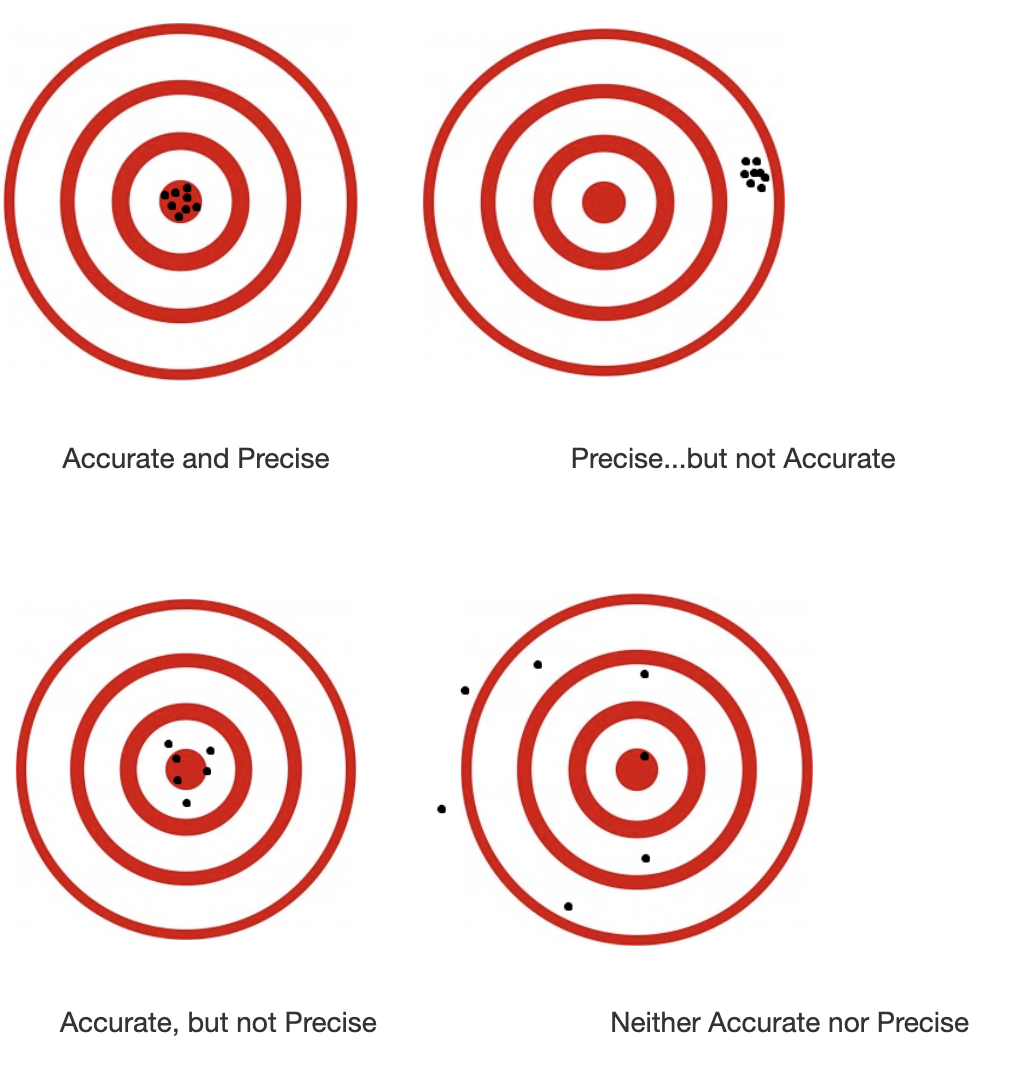


In [57]:
import seaborn as sns
import xgboost as xgb
sns.set(font_scale = 1.5)

Следующий график показывает, как часто переменная расщеплялась для построения дерева

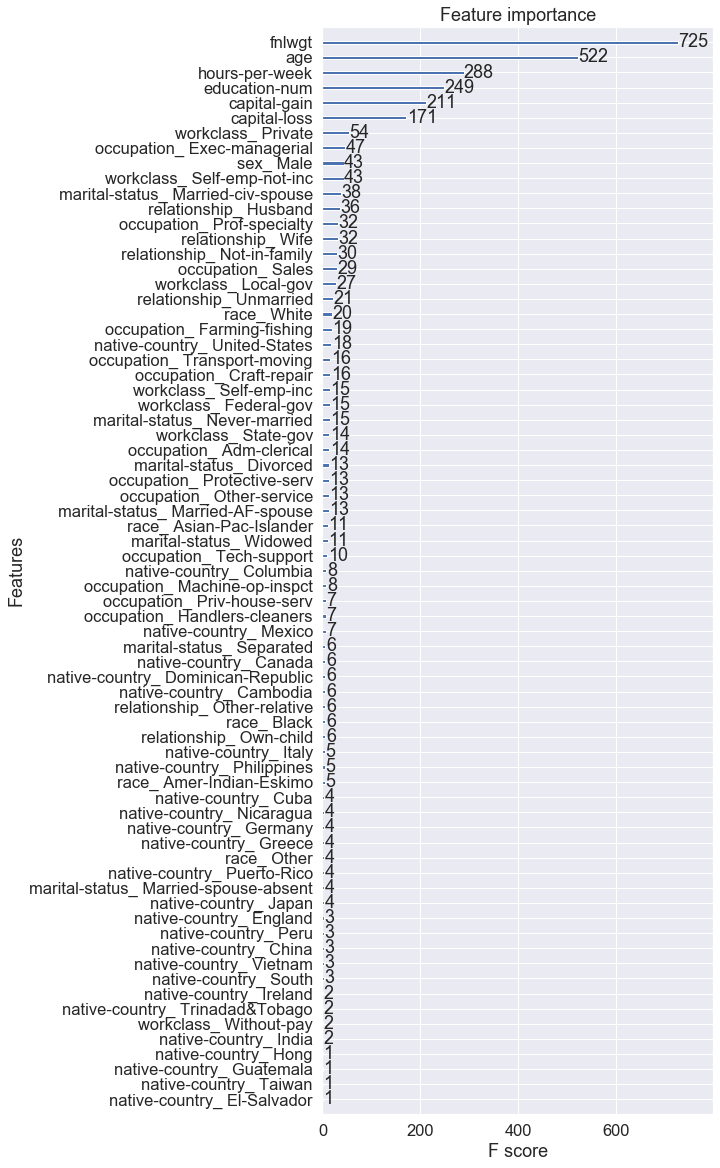

In [72]:
fig,ax = plt.subplots(1,1,figsize=(7,20))
xgb.plot_importance(model,ax=ax)

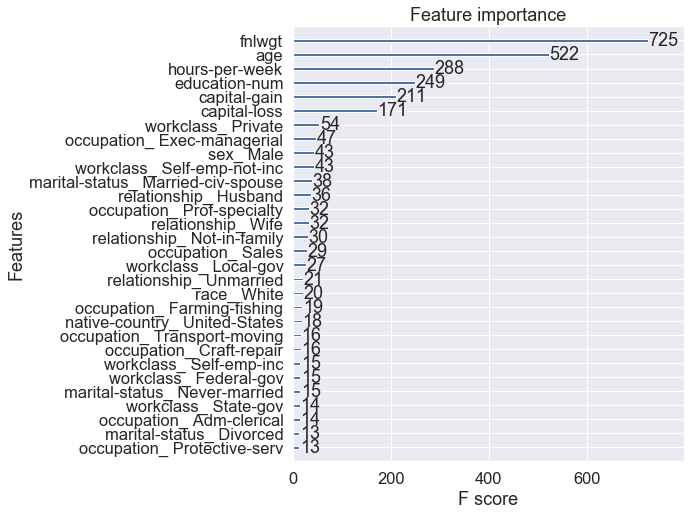

In [75]:
fig,ax = plt.subplots(1,1,figsize=(7,8))
xgb.plot_importance(model,ax=ax, max_num_features = 30)# показать первые 30 информативным переменных

### Замечание
Общее наблюдение показывает, что если отбросить некую долю фичей, упадет качество на тренировке, но вырастит на тестовой. Сколько именно надо отбросить, зависит от таблицы.

In [76]:
help(xgb.plot_importance)

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    grid : bool, Turn the axes grids on or off.  Default is True (On).
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
    
        * "weight" is the number of times a feature appears in a tree
        * "gain" is the average gain of splits which use the feature
        * "cover" is the average coverage of splits which use the featu